In [40]:

from sklearn.cluster import KMeans

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PowerTransformer

from sklearn.feature_selection import VarianceThreshold
from sklearn.neighbors import LocalOutlierFactor

from category_encoders import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

###
### Data

In [2]:
d_tr = pd.read_csv('/Users/antirrabia/Documents/01-GitHub/DataMining-_-/CSV/HousePrices/train.csv', index_col='Id')
d_te = pd.read_csv('/Users/antirrabia/Documents/01-GitHub/DataMining-_-/CSV/HousePrices/test.csv', index_col='Id')

###
> **Training** and **test** sets  
> Deliting a **zero varianza** columns

In [3]:
# y = d_tr.SalePrice.copy()

# Utilities has just 2 categories, and one of them
# just appears once so we delete the whole column.
d_tr = d_tr.drop(columns='Utilities')
d_te = d_te.drop(columns='Utilities')


all_d = pd.concat([d_tr.copy(), d_te.copy()])

####
> A set of the **raw columns**

In [ ]:
raw_columns = set( all_d.columns )

###
## Imputing **nan**

> columns with **nan**

In [ ]:
nan_columns = all_d.columns[all_d.isna().any()].to_list()

print('number of columns that has nan: ', len(nan_columns)) #This inclued 'SalesPrice' columns

> **coustum** Functions and Transformers

In [4]:
# 34 columns with nan

def fillWithNone(df):
    ''' nan in 'PoolQC' means 'no pool' 
        nan in 'MiscFeature' means 'no misc feature'
        nan in 'Alley' means 'no alley acces'
        nan in 'Fence' means 'no fence'
        nan in 'FireplaceQu' means 'no Fireplace'
        nan in 'GarageType', 'GarageFinish', 'GarageQual',
            'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1'
            'BsmtFinType1', 'MasVnrType', 'MSSubClass'
            'GarageCond' replaced with 'None' too
    
        recive a df
    '''
    
    df = df.copy()
    
    columns = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 
               'FireplaceQu', 'GarageType', 'GarageFinish', 
               'GarageQual', 'GarageCond', 'BsmtQual',
               'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
               'BsmtFinType2', 'MasVnrType'
              ]
    
    for col in columns:
        df[col] = df[col].fillna('None')
    
    return df

def fillWithZero(df):
    ''' nan 
    
    '''
    
    df = df.copy()
    
    columns = ['GarageYrBlt', 'GarageArea', 'GarageCars',
               'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
               'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
               'MasVnrArea'
              ]
    
    for col in columns:
        df[col] = df[col].fillna(0)
    
    return df

def fillWithMode(df):
    ''' fill missing values with mode, median
    '''
    df = df.copy()
    
    columns = ['Electrical', 'KitchenQual', 'Exterior1st',
               'Exterior2nd', 'SaleType'
              ]
    
    for col in columns:
        df[col] = df[col].fillna(df[col].mode()[0])
    
    # filling with median of each 'Neighborhood'
    df['LotFrontage'] = (
                     df.groupby('Neighborhood')['LotFrontage']
                     .transform(lambda x: x.fillna(x.median()))
                    )  
    
    # nan means Typical
    df['Functional'] = df['Functional'].fillna('Typ')
    
    return df


def mszoning(df):
    ''' recives a DF this imputation takes place on test data only'''
    
    df = df.copy()
    
    idotrr = ( (df['Neighborhood'] == 'IDOTRR') & (df['MSZoning'].isna()) )
    mitchel = ( (df['Neighborhood'] == 'Mitchel') & (df['MSZoning'].isna()) )
    
    df.loc[ idotrr , 'MSZoning'] = 'RM'
    df.loc[ mitchel, 'MSZoning'] = 'RL'
    
#     # to test this function out of here
#     temp = mszoning(d_te)
#     # lable index acces at [1916, 2217, 2251, 2905
#     temp.loc[[1916, 2217, 2251, 2905], 'MSZoning']
    
    return df
    
none_func = FunctionTransformer(fillWithNone, validate=False) 
zero_func = FunctionTransformer(fillWithZero, validate=False) 
mode_func = FunctionTransformer(fillWithMode, validate=False)
mszo_func = FunctionTransformer(mszoning, validate=False)

> getting the **imputer**

In [5]:
imputer = Pipeline([
                    ('withNone', none_func), 
                    ('withZero', zero_func), 
                    ('withMode', mode_func), 
                    ('mszoni', mszo_func)
                   ])

###
> Imputing

In [6]:
new_d = imputer.fit_transform(all_d)

###
> checking if there is any columns with **nan**

In [ ]:
new_d.columns[new_d.isna().any()].to_list()

In [ ]:
new_d.SalePrice.tail(7)

###
### Reducing low frequency categories

In [7]:
# Low frequency categories to 'Other'

def lower_than(df, col, percentage):
    ''' function that will merge low frequency classes into 
        a single class 'Others'
        
        parameters:
            df: a DataFrame
            col: column's name to work on
            percentage: the threshold 
            
        returns:
            df: the data frame with col's classes that are lowers
                than 'threshold' been repleced with 'Other' category
    '''
    
    # calculating the column frequency
    col_freq = df[col].value_counts(normalize=True)
    # the getting the column threshold 
    threshold = col_freq.quantile(q= percentage)
    # knowing the classes that are below the threshold
    less_freq_classes = col_freq[ col_freq <= threshold ]
    
    others = less_freq_classes.index.to_list()
    
    print(others)
    
    df[col] = df[col].replace(others, 'Others')
    
    return df

con1_others = ['RRAn', 'PosN', 'RRAe', 'PosA', 'RRNn', 'RRNe']
roofS_others = ['Gambrel', 'Flat', 'Mansard', 'Shed']
foun_others = ['Slab', 'Stone', 'Wood']
gara_others = ['None', 'Basment', '2Types', 'CarPort']
saleT_others = ['ConLD', 'CWD', 'ConLI', 'ConLw', 'Oth', 'Con']
saleC_others = ['Family', 'Alloca', 'AdjLand']
exte1_others = ['BrkComm', 'AsphShn', 'Stone', 'CBlock', 'ImStucc']
exte2_others = ['BrkComm', 'AsphShn', 'Stone', 'CBlock', 'ImStucc', 'Other']
lotC_others = ['FR2', 'FR3']

new_d['Condition1'] = new_d['Condition1'].map(lambda x: 'Others' if x in con1_others else x)
new_d['RoofStyle'] = new_d['RoofStyle'].map(lambda x: 'Others' if x in roofS_others else x)
new_d['Foundation'] = new_d['Foundation'].map(lambda x: 'Others' if x in foun_others else x)
new_d['GarageType'] = new_d['GarageType'].map(lambda x: 'Others' if x in gara_others else x)
new_d['SaleType'] = new_d['SaleType'].map(lambda x: 'Others' if x in saleT_others else x)
new_d['SaleCondition'] = new_d['SaleCondition'].map(lambda x: 'Others' if x in saleC_others else x)
new_d['Exterior1st'] = new_d['Exterior1st'].map(lambda x: 'Others' if x in exte1_others else x)
new_d['Exterior2nd'] = new_d['Exterior2nd'].map(lambda x: 'Others' if x in exte2_others else x)
new_d['LotConfig'] = new_d['LotConfig'].map(lambda x: 'Others' if x in lotC_others else x)


# Reducing to a BINARY CLASSES(just 2 clases)

# temp = new_d.copy()

landC_others = ['HLS', 'Bnk', 'Low']
cond2_others = ['Feedr', 'Artery', 'PosN', 'PosA', 'RRNn', 'RRAn', 'RRAe']
roofM_others = ['Tar&Grv', 'WdShake', 'WdShngl', 'Metal', 'Membran', 'Roll', 'ClyTile']
heati_others = ['GasW', 'Grav', 'Wall', 'OthW', 'Floor']
elect_others = ['FuseA', 'FuseF', 'FuseP', 'Mix']


new_d['LandContour'] = new_d['LandContour'].map(lambda x: 'Others' if x in landC_others else x)
new_d['Condition2'] = new_d['Condition2'].map(lambda x: 'Others' if x in cond2_others else x)
new_d['RoofMatl'] = new_d['RoofMatl'].map(lambda x: 'Others' if x in roofM_others else x)
new_d['Heating'] = new_d['Heating'].map(lambda x: 'Others' if x in heati_others else x)
new_d['Electrical'] = new_d['Electrical'].map(lambda x: 'Others' if x in elect_others else x)

# to encode using OneHot (17 so far)
cat_to_1Hot = {'Condition1': str, 'RoofStyle': str, 'Foundation': str, 'GarageType': str, 'SaleType': str, 
               'SaleCondition': str, 'Exterior1st': str, 'Exterior2nd': str, 'LotConfig': str, 'LandContour': str, 
               'Condition2': str, 'RoofMatl': str, 'Heating': str, 'Electrical': str }

# updating data types
new_d = new_d.astype(cat_to_1Hot)

###
> changing the **data types** to the columns that  we just reduced

In [ ]:
new_d[ list( cat_to_1Hot.keys() ) ].info()

###
> Reducing number of classes in **'Neighborhood'** and **'MSSubClass'**   Using **Clusters**

In [8]:
def make_clusters(df, col, y, n_cluster, merge=False):
    '''
        function to boil down a colum to n_cluster
        
        recive:
        
            df: a data frame 
            col: col to make cluster
            y: the response variable
            n_cluster: stamitation of number of cluster
            
        return:  
            a data frame with 'col' droped, and 'col' + '_cluster' column
            is added to the data frame

        
    '''
    col_clusters = KMeans(n_clusters=n_cluster, random_state=777)

    # 'Neighborhood' and 'MSSubClass' stats
    col_stats = df.groupby(col)[y].describe()

    # Getting clusters
    col_clusters.fit(col_stats)

    # preparing DF with cluster lables to merge
    new_name = col + '_Cluster'
    col_cluster_df = pd.DataFrame( { col: col_stats.index.to_list(),
                                     new_name: col_clusters.labels_.tolist()} )
    
    if merge:
        # merging the clusters with the data frame
        df = df.merge(col_cluster_df, how='left', on=col)

        df[new_name] = df[new_name].astype(str)
        
        result = df.drop(columns=col)
        
    else:
        result = col_cluster_df
    
    return result

In [38]:
y = new_d['SalePrice'].copy()

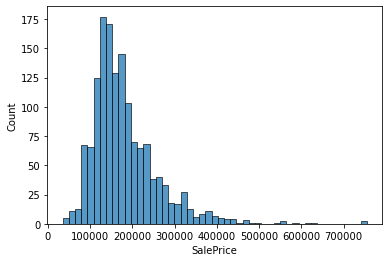

In [39]:
sns.histplot(y);

In [41]:
pt = PowerTransformer(method='box-cox')

In [42]:
y = pt.fit_transform(y)

ValueError: Expected 2D array, got 1D array instead:
array=[208500. 181500. 223500. ...     nan     nan     nan].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

###
> Features ingenering

In [9]:
# Creating a new feature 'PeakMonths', 'Unfinished',
# 'Splited', and TotalSF
peak_moS = [5, 6, 7]
unfi_hou = ['1.5Unf', '2.5Unf']
spli_hou = ['SFoyer', 'SLvl']

new_d['PeakMonths'] = new_d['MoSold'].map(lambda x: 'Peak' if x in peak_moS else 'Normal' )
new_d['Finished'] = new_d['HouseStyle'].map(lambda x: 'no' if x in unfi_hou else 'yes') 
new_d['Splited'] = new_d['HouseStyle'].map(lambda x: 'yes' if x in spli_hou else 'no')

new_d['TotalSF'] = new_d['TotalBsmtSF'] + new_d['1stFlrSF'] + new_d['2ndFlrSF']


# we will use the training data because if we uses new_d
# it has 'nan' in 'SalePrice'. test data does not have 'SalePrice'
# 'Neighborhood', 5, 'MSSubClass', 4
nei_cluster = make_clusters(d_tr.copy(), 'Neighborhood', 'SalePrice', 5)
mss_cluster = make_clusters(d_tr.copy(), 'MSSubClass', 'SalePrice', 4)

# merging the clusters with the data frame
# we got a 'nan' cluster becouse 'MSSubClass' in test
# has a '150' class that is just in test
new_d = new_d.merge(nei_cluster, how='left', on='Neighborhood')
new_d.drop(columns='Neighborhood', inplace=True)

new_d = new_d.merge(mss_cluster, how='left', on='MSSubClass')
new_d.drop(columns='MSSubClass', inplace=True)


# updating types
new_d = new_d.astype( {'PeakMonths':str, 'Finished':str, 'Splited':str,
                       'Neighborhood_Cluster': str, 'MSSubClass_Cluster': str} )

# updating cat_to_1Hot
cat_to_1Hot.update( {'PeakMonths':str, 'Finished':str, 'Splited':str,
                       'Neighborhood_Cluster': str, 'MSSubClass_Cluster': str} )

In [ ]:
new_d[cat_to_1Hot.keys()].info()

###
## Encoding Ordinal Categorical

In [10]:
##### ****** All writed by me ****** #####
##########################################

ord_cat_mapping = [
    {
        'col': 'FireplaceQu',
        'mapping': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
    },
    {
        'col': 'GarageQual',
        'mapping': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
    },
    {
        'col': 'GarageCond',
        'mapping': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
    },
    {
        'col': 'BsmtFinType1',
        'mapping': {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
    },
    {
        'col': 'BsmtFinType2',
        'mapping': {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
    },
    {
        'col': 'ExterQual',
        'mapping': {'Fa': 0, 'TA': 1, 'Gd': 2, 'Ex': 3}
    },
    {
        'col': 'ExterCond',
        'mapping': {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}
    },
    {
        'col': 'BsmtQual',
        'mapping': {'None': 0 , 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}
    },
    {
        'col': 'BsmtCond',
        'mapping': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4}
    },
    {
        'col': 'PoolQC',
        'mapping': {'None': 0, 'Fa': 1, 'Gd': 2, 'Ex': 3}
    },
    {
        'col': 'HeatingQC',
        'mapping': {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}
    },
    {
        'col': 'KitchenQual',
        'mapping': {'Fa': 0, 'TA': 1, 'Gd': 2, 'Ex': 3}
    },
    {
        'col': 'BsmtExposure',
        'mapping': {'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}
    },
    {
        'col': 'Functional',
        'mapping': {'Sev': 0, 'Maj2': 1, 'Maj1': 2, 'Mod': 3, 'Min2': 4, 'Min1': 5, 'Typ': 6}
    },
    {
        'col': 'GarageFinish',
        'mapping': {'None': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}
    },
    {
        'col': 'Fence',
        'mapping': {'None': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}
    },
    {
        'col': 'CentralAir',
        'mapping': {'N': 0, 'Y': 1}
    },
    {
        'col': 'PavedDrive',
        'mapping': {'N': 0, 'P': 1, 'Y': 2}
    },
    {
        'col': 'Street',
        'mapping': {'Grvl': 0, 'Pave': 1}
    },
    {
        'col': 'Alley',
        'mapping': {'None': 0, 'Grvl': 1, 'Pave': 2}
    },
    {
        'col': 'LandSlope',
        'mapping': {'Gtl': 0, 'Mod': 1, 'Sev': 2}
    },
    {
        'col': 'LotShape',
        'mapping': {'Reg': 0, 'IR1': 1, 'IR2': 2, 'IR3': 3}
    },
    {
        'col': 'HouseStyle', 
        'mapping': {'SLvl': 0, 'SFoyer': 0, '1Story': 1, '1.5Fin': 2, 
                    '1.5Unf': 2, '2Story': 3, '2.5Unf': 4, '2.5Fin': 4}
    }
]

# list of categorical columns(23)  
# that we just encoded
ord_cat_DONE = {'FireplaceQu': str, 'GarageQual': str,'GarageCond': str,'BsmtFinType1': str,
                 'BsmtFinType2': str,'ExterQual': str,'ExterCond': str,'BsmtQual': str,
                 'BsmtCond': str,'PoolQC': str,'HeatingQC': str,'KitchenQual': str,
                 'BsmtExposure': str,'Functional': str,'GarageFinish': str,'Fence': str, 
                 'CentralAir': str, 'PavedDrive': str,'Street': str,'Alley': str,
                 'LandSlope': str,'LotShape': str, 'HouseStyle': str}



# object columns (need to be analyzed)
cat_NoDone = ['MSZoning', 'BldgType', 'MasVnrType', 'MiscFeature']


###
> **Updating columns types** to better  
> distinguish **numerical** from **categorical**

In [22]:
# updating the types
# update the list of ordinal with 2 columns name
# that allredy are ordinal and encoded ('OverallQual', 'OverallCond')
 
ord_cat_DONE.update({'OverallQual': str, 'OverallCond': str})
new_d = new_d.astype(ord_cat_DONE)

# 2 more columns will concidere as categorical
cat_to_1Hot.update({'MoSold': str, 'YrSold': str})
new_d = new_d.astype(cat_to_1Hot)

In [27]:
new_d.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 2918
Columns: 83 entries, MSZoning to MSSubClass_Cluster
dtypes: float64(13), int64(20), object(50)
memory usage: 1.9+ MB


In [26]:
new_d.select_dtypes(exclude='number').info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 2918
Columns: 50 entries, MSZoning to MSSubClass_Cluster
dtypes: object(50)
memory usage: 1.1+ MB


In [28]:
new_d.select_dtypes('number').info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 2918
Columns: 33 entries, LotFrontage to TotalSF
dtypes: float64(13), int64(20)
memory usage: 775.4 KB


In [36]:
del temp01

In [37]:
numbers_col = new_d.select_dtypes('number')
numbers_col = numbers_col.columns.to_list()

print( len( numbers_col ) )
print( numbers_col )

33
['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice', 'TotalSF']


###
> doing the **Ordinal Encode**  
> and updating **columns types**

In [ ]:
## OrdinalEncoder
oe = OrdinalEncoder(mapping=ord_cat_mapping)

In [ ]:
# encoding Ordinal categories columns
new_d = oe.fit_transform(new_d)


###
> doing **OneHot Encoding**  

In [ ]:
# OneHot encoding
enc = OneHotEncoder(cols=cat_to_1Hot).fit(new_d.copy())

In [ ]:
new_d = enc.transform(new_d.copy())

In [ ]:
new_d2.head(7)

In [ ]:
new_d2['Condition1_1'].value_counts()

In [ ]:
new_d2.columns.to_list()

In [ ]:
len( new_d2.columns.to_list() )

# Testing the ordinal encoded

In [ ]:
new_d.info(verbose=True)

In [ ]:
temp01 = d_tr.info()